# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video. 


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually. 

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [1]:
import torch.nn.functional as F
import torch
import torchvision
import matplotlib.pyplot as plt
from pytorch_gan_metrics import get_fid
from torchvision.io import read_image
device = "cuda:3"

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 1000
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

/nfs/home/leo0511/CCBDA/HW3/CCBDA_HW3env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import glob
import os
train_dir = './mnist'
data_list = sorted(glob.glob(os.path.join(train_dir,'*png')))
print('Number of dataset:',len(data_list))


Number of dataset: 60000


Let's test it on our dataset ...

In [3]:
from torch.utils.data import Dataset
import os
from PIL import Image

class Dataset(Dataset):
    def __init__(self, transform, root='./mnist' ):
        self.paths = sorted(glob.glob(os.path.join(root, "*.png")))
        print("number of training data: ", len(self.paths))
        self.transform = transform
        

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        img = self.transform(img)
        #print("imag size",img.shape)

        return img

In [5]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 28
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    dataset = Dataset(transform=data_transform)

    return dataset
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    #print("image size ", reverse_transforms(image).size)
    plt.imshow(reverse_transforms(image))
    return reverse_transforms(image)

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,num_workers=16)

number of training data:  60000


/tmp/ipykernel_2320393/1217489402.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


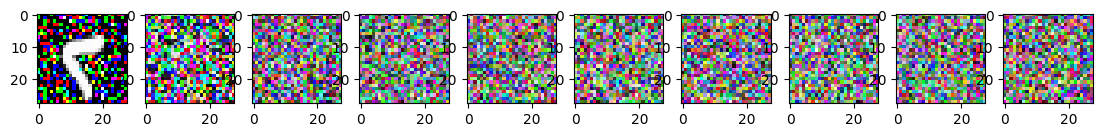

In [6]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [6]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            #print("x shape",x.shape)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            #print(residual_x.shape)
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet().to(device)
x = torch.randn((1,3,28,28)).to(device)
t = torch.randint(0, T, (1,)).long().to(device)
model(x,t)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  3692003


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [8]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation 
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [9]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    #print(x.device)
    #print(t.device)
    betas_t = get_index_from_list(betas, t, x.shape)
    #print("a")
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    #print("b")
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    #print("c")
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    #print("d")
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    #print(img.shape)

    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 8
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        print(t)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize+1))
            show_tensor_image(img.detach().cpu())
    plt.show()            
    return img

@torch.no_grad()
def test():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    #plt.figure(figsize=(15,15))
    #plt.axis('off')
    num_images = 1000
    t = torch.full((1,), 0, device=device, dtype=torch.long)
    #stepsize = int(T/num_images)
    imgs = []
    for i in range(num_images):
        imgs.append(sample_timestep(img, t))
    FID = get_fid(imgs, './mnist.npz')
                
    return FID

## Training

In [14]:
from torch.optim import Adam
from tqdm import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!
len_train_data = len(dataloader)
for epoch in range(epochs):
    running_loss = 0.0
    with tqdm(total=len_train_data, ncols=100, position=0, leave=True, desc="Training: ") as pbar:
      for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        print(t.shape)
        print(batch.shape)
        loss_b = get_loss(model, batch, t)
        loss_b.backward()
        running_loss += loss_b
        optimizer.step()
        pbar.set_postfix_str(f"loss_b: {loss_b:.4f}")
        pbar.update(1)
      loss = running_loss/float(len_train_data)

    if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      sample_plot_image()
    
    print(", ".join([
            f"Epoch {epoch:3d}/{args.epochs:3d}",
            f"train_loss: {loss:.4f}",
            f"val_loss: {val_loss:.4f}",
            f"test_acc: {acc:.4f}",
            f"lr: {current_lr}"
        ]))
      

Training:   0%|                                                             | 0/468 [00:00<?, ?it/s]

torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   1%|▏                                    | 3/468 [00:07<15:02,  1.94s/it, loss_b: 0.7126]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   1%|▌                                    | 7/468 [00:07<04:32,  1.69it/s, loss_b: 0.5913]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   2%|▊                                   | 11/468 [00:07<02:06,  3.62it/s, loss_b: 0.4672]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   3%|█                                   | 13/468 [00:08<01:34,  4.84it/s, loss_b: 0.4307]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   4%|█▎                                  | 17/468 [00:08<00:59,  7.53it/s, loss_b: 0.4042]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   4%|█▌                                  | 21/468 [00:08<00:43, 10.38it/s, loss_b: 0.3504]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   5%|█▊                                  | 24/468 [00:08<00:34, 12.75it/s, loss_b: 0.3375]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   6%|██▏                                 | 28/468 [00:09<00:32, 13.42it/s, loss_b: 0.3026]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   6%|██▎                                 | 30/468 [00:09<00:32, 13.29it/s, loss_b: 0.2911]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   7%|██▌                                 | 34/468 [00:09<00:30, 14.05it/s, loss_b: 0.2770]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   8%|██▉                                 | 38/468 [00:09<00:29, 14.46it/s, loss_b: 0.2671]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   9%|███                                 | 40/468 [00:09<00:30, 14.21it/s, loss_b: 0.2447]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:   9%|███▍                                | 44/468 [00:10<00:29, 14.20it/s, loss_b: 0.2406]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:  10%|███▋                                | 48/468 [00:10<00:26, 15.98it/s, loss_b: 0.2969]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:  11%|███▊                                | 50/468 [00:10<00:27, 15.48it/s, loss_b: 0.3173]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:  12%|████▏                               | 54/468 [00:10<00:27, 14.88it/s, loss_b: 0.3174]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:  12%|████▍                               | 58/468 [00:11<00:27, 15.04it/s, loss_b: 0.3031]

torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])
torch.Size([128])
torch.Size([128, 3, 28, 28])


Training:  13%|████▌                               | 59/468 [00:11<01:18,  5.21it/s, loss_b: 0.3031]


KeyboardInterrupt: 

In [10]:
@torch.no_grad()
def test(model, device, IMG_SIZE, betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas,posterior_variance):
    # Sample noise
    img_size = IMG_SIZE
    
    #plt.figure(figsize=(15,15))
    #plt.axis('off')
    num_images = 2
    #t = torch.full((1,), 0, device=device, dtype=torch.long)
    #stepsize = int(T/num_images)
    
    imgs = torch.randn((2, 3, img_size, img_size), device=device)
        
        #print(imgs.shape)
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        #print(model(img,t).shape)
        imgs = sample_timestep(imgs, t)

        #print(t.device)
        #print(img.shape)
        #print(t.shape)
        #imgs.append(img)
        #print(img_output.shape)
        #print(sample_timestep(img, t).device)
    #imgs = torch.stack(imgs, dim=0)
    FID = get_fid(imgs, './mnist.npz',device=device, use_torch=True)
                
    return FID
#device = "cuda:3"
test(model, device, IMG_SIZE, betas, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas,posterior_variance)

25753.156752750958

In [2]:
!jupyter nbconvert --to script diffusion_model.ipynb

[NbConvertApp] Converting notebook diffusion_model.ipynb to script
[NbConvertApp] Writing 14922 bytes to diffusion_model.py


In Table 2, we show the sample quality effects of reverse process parameterizations and training
objectives (Section 3.2). We find that the baseline option of predicting µ˜ works well only when
trained on the true variational bound instead of unweighted mean squared error, a simplified objective
akin to Eq. (14). We also see that learning reverse process variances (by incorporating a parameterized
diagonal Σθ(xt) into the variational bound) leads to unstable training and poorer sample quality
compared to fixed variances. Predicting , as we proposed, performs approximately as well as
predicting µ˜ when trained on the variational bound with fixed variances, but much better when trained
with our simplified objective.


iffusion models scale down the data with each forward process step (by a √
1 − βt factor)
so that variance does not grow when adding noise, thus providing consistently scaled inputs
to the neural net reverse process. NCSN omits this scaling factor.


In [2]:
import torch
ab = torch.tensor([])
a = torch.randn((5,3,28,28))
b = torch.randn((5,3,28,28))
c = torch.randn((5,3,28,28))
ab = torch.cat((ab,a))
abc = torch.cat((ab,c))
print(ab.shape)
print(abc.shape)

torch.Size([5, 3, 28, 28])
torch.Size([10, 3, 28, 28])


In [7]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam
from torchvision import transforms as T, utils

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from PIL import Image
from tqdm.auto import tqdm
#from ema_pytorch import EMA

#from accelerate import Accelerator

#from denoising_diffusion_pytorch.version import __version__

# constants

ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

# helpers functions

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# small helper modules

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = 2, p2 = 2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1)
    )

class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o ... -> o 1 1 1', 'mean')
        var = reduce(weight, 'o ... -> o 1 1 1', partial(torch.var, unbiased = False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(x, normalized_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# sinusoidal positional embeds

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class RandomOrLearnedSinusoidalPosEmb(nn.Module):
    """ following @crowsonkb 's lead with random (learned optional) sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

# model

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        self_condition = False,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond = None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim = 1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [12]:
model = Unet(dim = 64,dim_mults = (1,2,4)).to(device)
T=1000
x = torch.randn((1,3,28,28)).to(device)
t = torch.randint(0, T, (1,)).long().to(device)
print(model(x,t).shape)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

torch.Size([1, 3, 28, 28])
Num params:  9901699


Unet(
  (init_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): WeightStandardizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightStandardizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (1): ResnetBlock(
 